### Import required packages

In [1]:
import random
import math
import matplotlib.pyplot as plt
import numpy as np

### Load and renewable generation is taken from village Palari in Chhattisgarh (cite: Paper)

In [2]:
# Daily load is taken out from the paper
load_profile = [18, 5, 5, 5, 5, 1, 7, 3, 4, 22, 24, 25, 26, 27, 28, 27, 23, 21, 32, 27, 34, 24, 25, 20]

# Set a fixed seed for reproducibility
random.seed(42)

# Wind energy is also from the paper as an random function
wind_list = [random.randint(0,15) for _ in range(24)]
wind = np.array(wind_list)

# Solar as shown in the paper is a half sinusoidal function between 6am to 6pm
# Generate 12 points between 0 and pi (half of the sine wave)
x = np.linspace(0, np.pi, 12)

# Apply the sine function to get a half-sinusoidal distribution
sinusoidal_values = np.sin(x)

# Normalize the values to a specific range if needed (optional)
# For example, scaling between 0 and 1
normalized_values = sinusoidal_values / np.max(sinusoidal_values)

# Peak Solar power is taken as 20KW
solar_generation = np.round(normalized_values,2) * 20

# Non Solar hours added
solar_list = [0] * 6 + solar_generation.tolist() + [0] * 6
solar = np.array(solar_list)

# Hourly Renewable generation from wind and solar
renewable_generation = [a+round(b,1) for (a,b) in zip(wind,solar)]



### To microgrid add a micro reactor with adjustable output

In [3]:
# Introduce Nuclear Power. Assumed it to have load following properties from 50% to 100%
nuclear_min = 8  # Minimum nuclear power
nuclear_max = 8  # Maximum nuclear power

### Also add a Battery storage to cater for low Renewables generations

In [4]:
# Introduce Storage device
battery_capacity = 150  # Total battery capacity
battery_soc = 0.37 * battery_capacity  # Initial state of charge (37% of capacity)
battery_max_charge_rate = 10  # Assume a maximum charge rate of 10 units/hour
battery_max_discharge_rate = 10  # Assume a maximum discharge rate of 10 units/hour


#### The goal is to simulate the power balance in a microgrid with solar, wind, nuclear, and battery storage based on a given load profile.
#### Steps:
#### 1. Adjust nuclear power to minimize excess energy when renewable generation exceeds load + battery charging capacity.
#### 2. Track battery SOC (state of charge) throughout the day.
#### 3. Ensure load is served by a combination of renewables, nuclear, and battery power.


In [5]:
# Initialise list to store results
nuclear_power_output = []
battery_soc_history = []
excess_energy_history = []

# Do hourly analysis for a typical day
for hour in range(24):
    # Calculate the initial required nuclear power assuming no excess. 
    # 1. Calculate minimum requirement of deficit and maximum nuke power
    # 2. If it's less than nuke minimum, then choose nuke minimum
    nuclear_power = max(nuclear_min, min(nuclear_max, load_profile[hour] - renewable_generation[hour]))
    
    # Check the total available generation (renewable + nuclear)
    total_generation = renewable_generation[hour] + nuclear_power
    
    # If generation exceeds load and battery charging, adjust nuclear to minimize excess
    excess_energy = total_generation - load_profile[hour]
    # print(excess_energy)

    # Excess energy to be used for battery charging
    if excess_energy > 0:
        # Calculate the amount of energy that can be stored in the battery
        available_battery_capacity = battery_capacity - battery_soc
        # We can charge the battery only to the maximum charging rate
        charge_to_battery = min(excess_energy, available_battery_capacity, battery_max_charge_rate)
        battery_soc += charge_to_battery
        excess_energy -= charge_to_battery
        
    # If generation is less than the load, discharge battery if possible
    elif total_generation < load_profile[hour]:
        deficit_energy = load_profile[hour] - total_generation
        # Limit the discharge to maximum discharge rate of battery
        discharge_from_battery = min(deficit_energy, battery_soc, battery_max_discharge_rate)
        battery_soc -= discharge_from_battery
        deficit_energy -= discharge_from_battery
        # Generation could not match the load
        if deficit_energy > 0:
            excess_energy = -1
        else:
            excess_energy = 0
        
    # Store the results for each hour
    nuclear_power_output.append(round(nuclear_power,1))
    battery_soc_history.append(round(battery_soc,1))
    excess_energy_history.append(round(excess_energy,1))
    deficit_hours = excess_energy_history.count(-1)
    wasted_energy = [a if a>0 else 0 for a in excess_energy_history]

# Convert results to numpy arrays for easier analysis
nuclear_power_output = np.array(nuclear_power_output)
battery_soc_history = np.array(battery_soc_history)
excess_energy_history = np.array(excess_energy_history)

print(f'Hourly wind generation: {wind}')
print(f'Hourly solar generation: {np.round(solar,2)}')
print(f'Hourly renewable generation: {renewable_generation}')
print(f'Hourly Load: {load_profile}')
print(f'Nuclear Power Generated: {nuclear_power_output}')
print(f'Battery State of Charge: {battery_soc_history}')
print(f'Excess charge history: {excess_energy_history}')
print(f'Hours of power cut: {deficit_hours}')
print(f'Unutilised energy: {round(sum(wasted_energy),2)}')

Hourly wind generation: [ 3  0  8  7  7  4  3  2 13  1  0  2  6  7  0  6 13  7 14  8  0  5 13 10]
Hourly solar generation: [ 0.   0.   0.   0.   0.   0.   0.   5.6 11.  15.2 18.4 20.  20.  18.4
 15.2 11.   5.6  0.   0.   0.   0.   0.   0.   0. ]
Hourly renewable generation: [3.0, 0.0, 8.0, 7.0, 7.0, 4.0, 3.0, 7.6, 24.0, 16.2, 18.4, 22.0, 26.0, 25.4, 15.2, 17.0, 18.6, 7.0, 14.0, 8.0, 0.0, 5.0, 13.0, 10.0]
Hourly Load: [18, 5, 5, 5, 5, 1, 7, 3, 4, 22, 24, 25, 26, 27, 28, 27, 23, 21, 32, 27, 34, 24, 25, 20]
Nuclear Power Generated: [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
Battery State of Charge: [ 48.5  51.5  61.5  71.5  81.5  91.5  95.5 105.5 115.5 117.7 120.1 125.1
 133.1 139.5 134.7 132.7 136.3 130.3 120.3 110.3 100.3  90.3  86.3  84.3]
Excess charge history: [ 0.   0.   1.   0.   0.   1.   0.   2.6 18.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.  -1.  -1.  -1.   0.   0. ]
Hours of power cut: 3
Unutilised energy: 22.6


### Plot the results

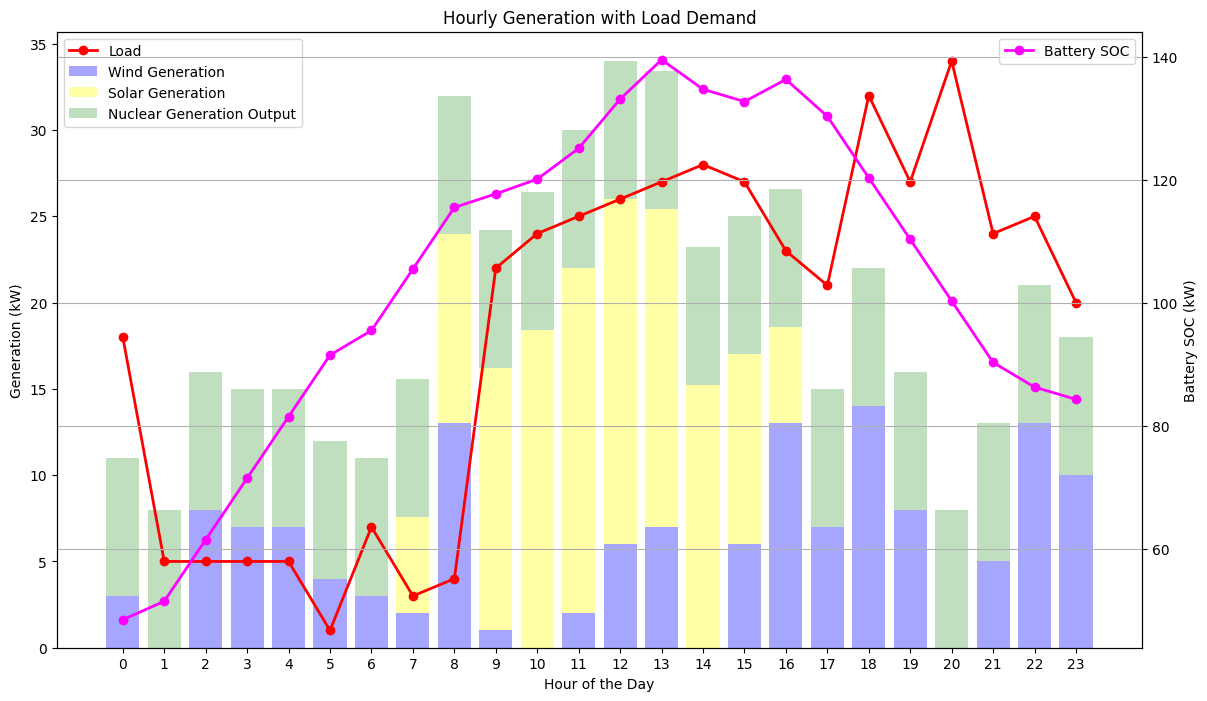

In [14]:
# Hours of the day
hours = [i for i in range(len(load_profile))]

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(14, 8))  # Set figure size to 14x8 inches

# Plot stacked bar chart for wind and solar generation
ax1.bar(hours, wind, label='Wind Generation', color='blue', alpha=0.35)
ax1.bar(hours, solar, bottom=wind, label='Solar Generation', color='yellow', alpha=0.35)
ax1.bar(hours, nuclear_power_output, bottom=wind + solar, label='Nuclear Generation Output', color='green', alpha=0.25)
ax1.plot(hours, load_profile, color='red', label='Load', linewidth=2, marker='o')

# Set x-axis to represent hours of the day
ax1.set_xticks(hours)
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Generation (kW)')

# Create a second y-axis to plot the load as a line
ax2 = ax1.twinx()
ax2.plot(hours, battery_soc_history, label='Battery SOC', color='magenta', linewidth=2, marker='o')
ax2.set_ylabel('Battery SOC (kW)')

# Excess Power
#ax3 = ax1.twinx()

#ax3.spines['right'].set_position(('outward', 60))  # Move third axis 60 pixels away from the second
#ax3.plot(hours, excess_energy_history, label='Excess Power', color='yellow', linewidth=2, marker='x')
#ax3.set_ylabel('Excess Energy (kW)')

plt.plot()

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
#ax3.legend(loc='upper center')

# Add a title and show the plot
plt.title('Hourly Generation with Load Demand')
plt.grid(True)
plt.show()

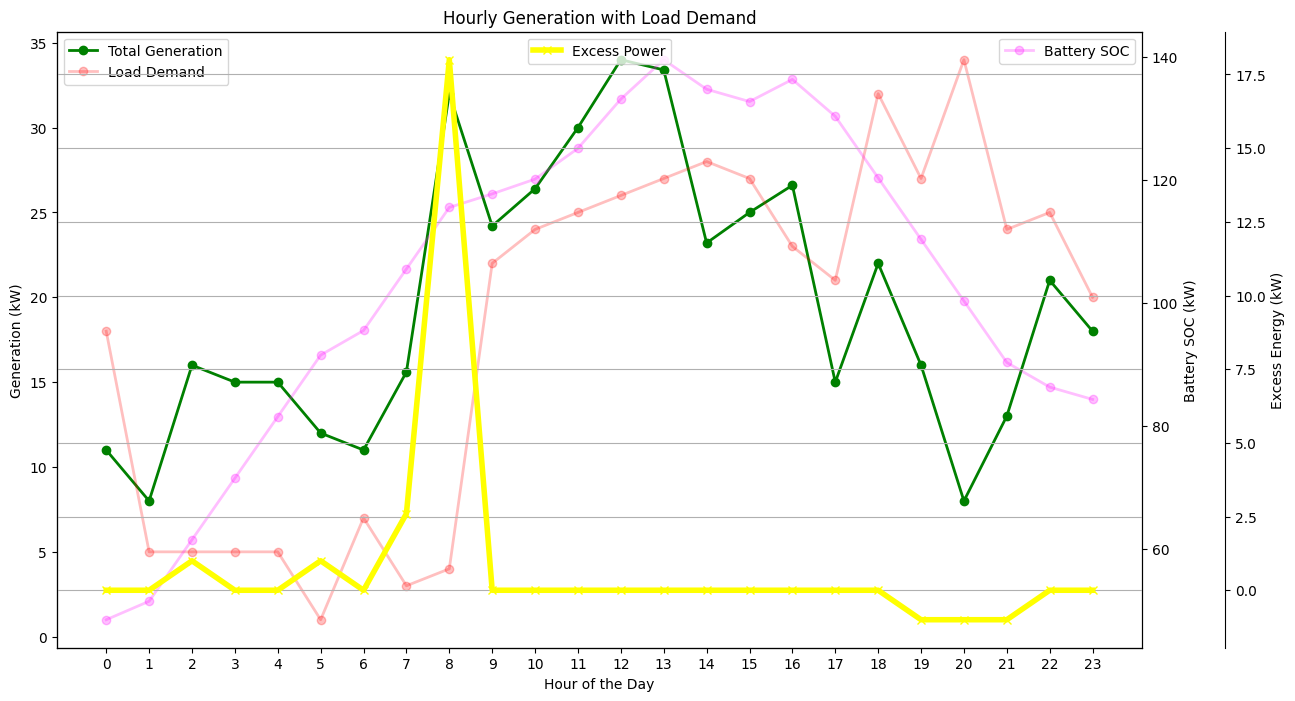

In [18]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(14, 8))  # Set figure size to 14x8 inches

total_generation = wind + solar + nuclear_power_output

# Plot stacked bar chart for wind and solar generation
#ax1.bar(hours, wind, label='Wind Generation', color='blue')
#ax1.bar(hours, solar, bottom=wind, label='Solar Generation', color='purple')
#ax1.bar(hours, nuclear_power_output, bottom=wind + solar, label='Nuclear Generation Output', color='green')
ax1.plot(hours, total_generation, color='green', label='Total Generation', linewidth=2, marker='o')
ax1.plot(hours, load_profile, color='red', label='Load Demand', linewidth=2, alpha=0.25, marker='o')

# Set x-axis to represent hours of the day
ax1.set_xticks(hours)
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Generation (kW)')

# Create a second y-axis to plot the load as a line
ax2 = ax1.twinx()
ax2.plot(hours, battery_soc_history, label='Battery SOC', color='magenta', alpha=0.25, linewidth=2, marker='o')
ax2.set_ylabel('Battery SOC (kW)')

# Excess Power
ax3 = ax1.twinx()

ax3.spines['right'].set_position(('outward', 60))  # Move third axis 60 pixels away from the second
ax3.plot(hours, excess_energy_history, label='Excess Power', color='yellow', linewidth=4, marker='x')
ax3.set_ylabel('Excess Energy (kW)')

plt.plot()

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax3.legend(loc='upper center')

# Add a title and show the plot
plt.title('Hourly Generation with Load Demand')
plt.grid(True)
plt.show()

In [8]:
# Time axis for the 24-hour period
#hours = [i for i in range(len(load_profile))]

# Plot the load profile, renewable generation, and nuclear power output
#plt.figure(figsize=(14, 8))

# Load Profile
#plt.plot(hours, load_profile, label='Load Profile', color='black', linewidth=2, linestyle='--')
# Renewable Generation (Solar + Wind)
#plt.plot(hours, renewable_generation, label='Renewable Generation (Solar + Wind)', color='green', linewidth=2)
# Nuclear Power Output
#plt.plot(hours, nuclear_power_output, label='Nuclear Power Output', color='orange', linewidth=2)
# Battery SOC
#plt.plot(hours, battery_soc_history, label='Battery SOC', color='blue', linewidth=2)
# Excess Power
#plt.plot(hours, excess_energy_history, label='Excess Power', color='red', linewidth=2)

# Add grid, legend, and labels
#plt.grid(True)
#plt.legend(loc='upper left')
#plt.xlabel('Hour of the Day')
#plt.ylabel('Power (Units)')
#plt.title('Microgrid Power Distribution and Battery SOC Over 24 Hours')
#plt.xticks(hours)  # Mark every hour

# Show the plot
#plt.tight_layout()
#plt.show()
